#Nama   : Leonardo Caprio
#NIM    : 1103184204
#Kelas  : TK-44-G4
#Importing necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Loading Dataset from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

In [3]:
#loading training file and test file
training_file = "/content/drive/MyDrive/Datasets/German Traffic/train.p"
testing_file = "/content/drive/MyDrive/Datasets/German Traffic/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [4]:
#load csv for sign names
sign_name_df = pd.read_csv('/content/drive/MyDrive/Datasets/German Traffic/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


#Data Visualisation and Preparation

In [5]:
#Setting up plot
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
#features and labels
X, y = train['features'], train['labels']

# list to np
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# features and labels
X_test, y_test = test['features'], test['labels']

# list to np
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


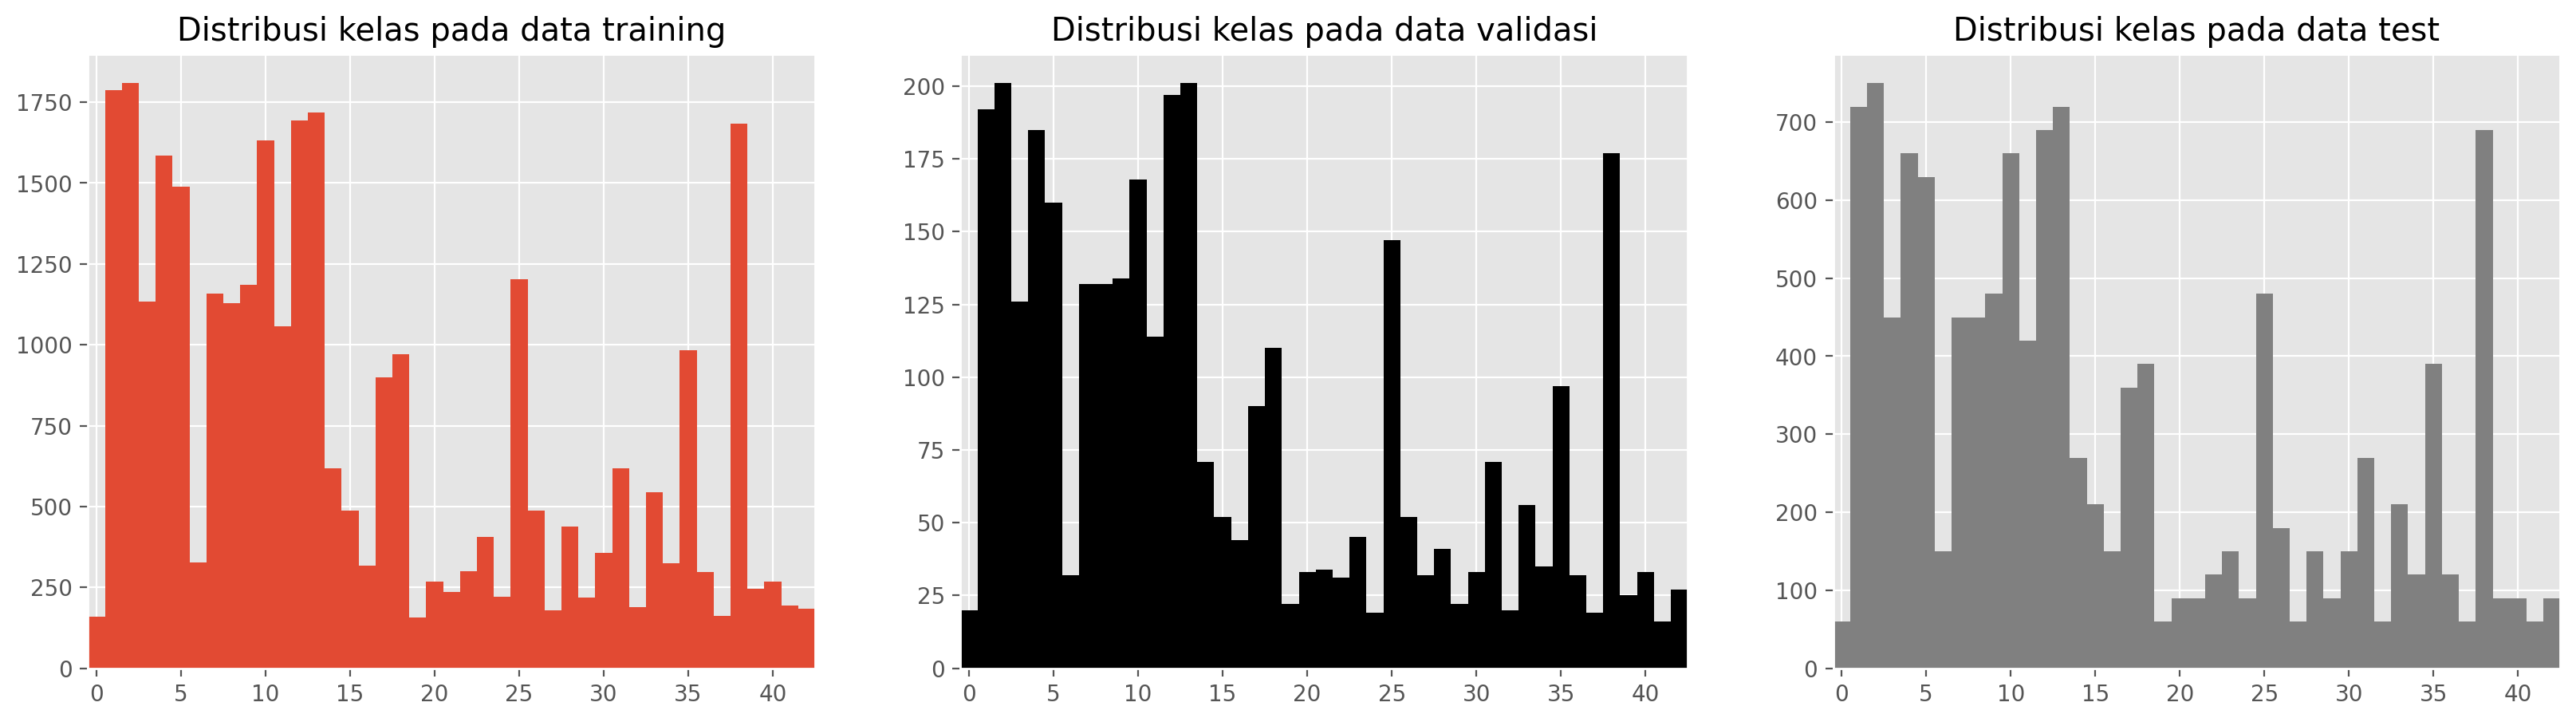

In [8]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [9]:
# Labels to One-Hot Encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical (y_train,43)
y_val = to_categorical(y_val,43)

#Making The Model

In [10]:
#Early Stopping
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

In [11]:
#Adding Layers
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [13]:
#Compiling Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
#training
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 14s 7ms/step - loss: 1.6313 - accuracy: 0.5764 - val_loss: 0.2963 - val_accuracy: 0.9247
Epoch 2/25
979/979 [==============================] - 6s 6ms/step - loss: 0.5208 - accuracy: 0.8457 - val_loss: 0.1845 - val_accuracy: 0.9534
Epoch 3/25
979/979 [==============================] - 6s 6ms/step - loss: 0.3655 - accuracy: 0.8938 - val_loss: 0.1335 - val_accuracy: 0.9718
Epoch 4/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2922 - accuracy: 0.9132 - val_loss: 0.1008 - val_accuracy: 0.9698
Epoch 5/25
979/979 [==============================] - 7s 7ms/step - loss: 0.2429 - accuracy: 0.9296 - val_loss: 0.0649 - val_accuracy: 0.9856
Epoch 6/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2271 - accuracy: 0.9367 - val_loss: 0.1190 - val_accuracy: 0.9718
Epoch 7/25
979/979 [==============================] - 5s 5ms/step - loss: 0.2147 - accuracy: 0.9397 - val_loss: 0.0570 - val_accuracy: 0.9874
Epoch

In [14]:
model.save("my_model.h5")
#Saving Model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Model Evaluation

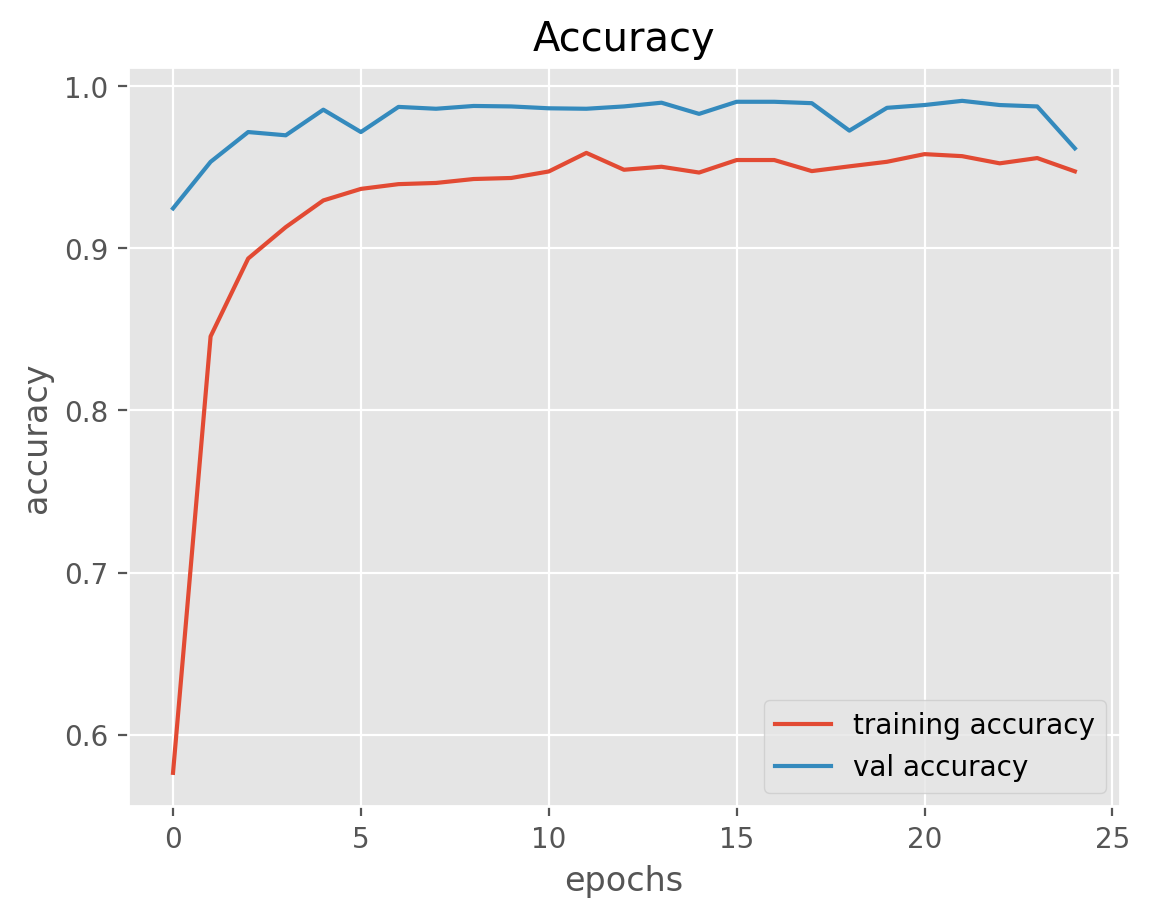

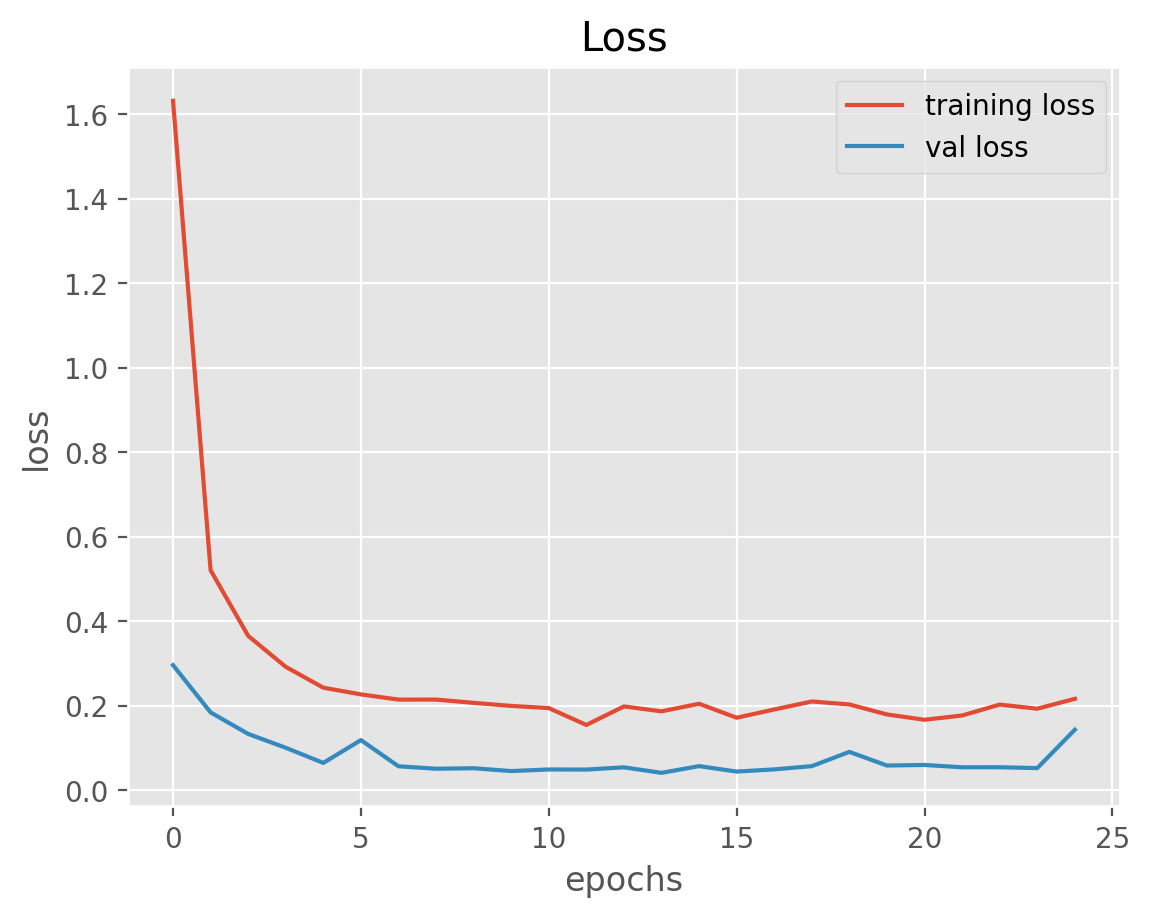

In [15]:
#Accuracy Visual
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Loss Visual
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
#accuracy
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 1s 3ms/step


0.9203483768804434

In [17]:
#classification Report
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        60
           1       0.92      0.92      0.92       720
           2       0.87      0.95      0.90       750
           3       0.82      0.92      0.87       450
           4       0.96      0.93      0.94       660
           5       0.86      0.87      0.87       630
           6       0.98      0.76      0.86       150
           7       0.97      0.80      0.87       450
           8       0.81      0.91      0.86       450
           9       0.98      0.96      0.97       480
          10       1.00      0.98      0.99       660
          11       0.97      0.89      0.93       420
          12       0.97      0.94      0.95       690
          13       0.93      0.99      0.96       720
          14       0.96      0.99      0.97       270
          15       0.93      1.00      0.96       210
          16       0.92      0.99      0.96       150
          17       1.00    